In [2]:
import pandas as pd
data=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [3]:
import math
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense,MaxPooling1D,Conv1D
from tensorflow.keras.initializers import GlorotUniform, HeNormal
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(101)


In [4]:
def train_test_split(data,n_test):
    return data[:-n_test],data[-n_test:]

def series_to_supervised(data,n_in,n_out=1):
    df=pd.DataFrame(data)
    cols=list()
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
    
    for i in range(0,n_out):
        cols.append(df.shift(-i))
    
    agg=pd.concat(cols,axis=1)
    agg.dropna(inplace=True)
    return agg.values

def model_fit(train,config):

    n_input, n_filters, n_kernel, n_epochs, n_batch= config

    data=series_to_supervised(train,n_input)
    
    train_x, train_y=data[:,:-1],data[:,-1]
    train_x=train_x.reshape((train_x.shape[0],train_x.shape[1],1))
    model=Sequential()
    model.add(Conv1D(filters=n_filters,kernel_size=n_kernel,activation='relu',input_shape=(n_input,1),kernel_initializer=HeNormal())) #,padding='same'
    model.add(Conv1D(filters=n_filters,kernel_size=n_kernel,activation='relu')) #,padding='same'
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='adam')

    model.fit(train_x,train_y,epochs=n_epochs, batch_size=n_batch,verbose=0)
    return model

def model_predict(model,history,config):
    n_input,_,_,_,_=config
    x_input=np.array(history[-n_input:]).reshape((1,n_input,1))
    #print(x_input)
    y_hat=model.predict(x_input,verbose=0)
    return y_hat[0]

def measure_rmse(actual,prediction):
    return math.sqrt(metrics.mean_squared_error(actual,prediction,squared=False))

def walk_forward_validation(data,n_test,cfg):
    predictions=list()
    train,test=train_test_split(data,n_test)

    model=model_fit(train,cfg)

    history=[x for x in train]
    
    for i in range(len(test)):
        yhat=model_predict(model,history,cfg)
        predictions.append(yhat.round())
        history.append(test[i])
    error=measure_rmse(test,predictions)
    print(" > %.3f " %error)
    return error
def repeat_evaluate(data,config,n_test,n_repeats=5):
    scores=[walk_forward_validation(data,n_test,config) for _ in range(int(n_repeats))]
    return scores
def summarize_scores(name,scores):
    scores_m, score_std= np.mean(scores), np.std(scores)
    print("%s: %.3f RMSE (+/- %3f" %(name,scores_m,score_std))
    plt.boxplot(scores)
    plt.show()


In [5]:
data=data.values

In [46]:
round(5.4)

5

###without round the average is 147.56 and variation is 7-10

In [6]:
n_test=164
config=[6,256,3,100,100]
# scores=repeat_evaluate(data,config,n_test)

# summarize_scores('Persistence',scores)

In [7]:
n_test=164
config=[12,256,3,100,100]
predictions=list()
train,test=train_test_split(data,n_test)

model=model_fit(train,config)

history=[x for x in train]

for i in range(len(test)):
    yhat=model_predict(model,history,config)
    predictions.append(yhat.round())
    history.append(test[i])
error=measure_rmse(test,predictions)
print(" > %.3f " %error)

 > 29.232 


In [8]:
test_np=list()
for i in range(test.shape[0]):
    test_np.append(test[i][0])

In [9]:
prediction_np=list()
for i in range(test.shape[0]):
    prediction_np.append(predictions[i][0].round())

In [10]:
test_np=np.array(test_np)
#test_np

In [11]:
prediction_np=np.array(prediction_np)
#prediction_np

In [12]:
prediction_data=pd.DataFrame({'test':test_np,'predict':prediction_np})
prediction_data.head()

,test,predict
0,1591093,1590727.0
1,1592209,1591991.0
2,1593700,1593227.0
3,1595931,1594811.0
4,1598389,1597364.0


In [13]:
data_2=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data_2.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [14]:
new_predict=pd.concat([prediction_data,pd.DataFrame(data_2.index[-164:])],axis=1)

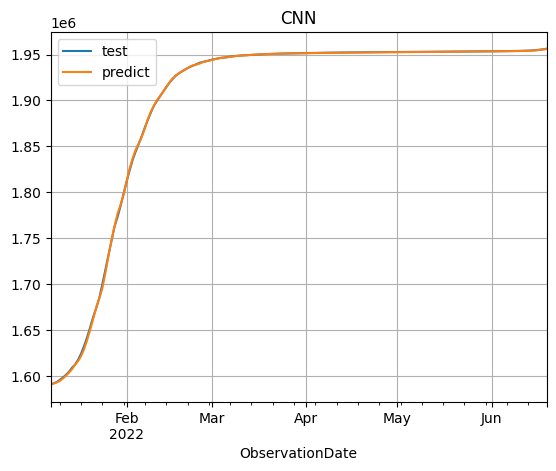

In [16]:
from matplotlib import pyplot as plt
plt.rcParams["savefig.dpi"] = 360
new_predict.plot(x='ObservationDate')
plt.title('CNN')
plt.grid()